In [1]:
import json
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectFromModel, SelectPercentile
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score
from sklearn.base import TransformerMixin
from torch import nn
from torch.utils.data import DataLoader

In [2]:
#Construct Neural Network architectures using Pytorch nn module.
class NeuralNetwork(nn.Module): #Without dropout layers
    def __init__(self, n_inputs, n_outputs = 1, n_layers = 1, n_neurons_per_layer = None, leaky_slope = 0.01):
        if n_layers > 0:
            try:
                assert n_neurons_per_layer is not None
                assert len(n_neurons_per_layer) == n_layers
            except Exception as e:
                raise ValueError("provide numbers of neurons per layer defined by n_layers")
        
        super().__init__()
        self.flatten = nn.Flatten()
        if n_layers >= 1:
            stack = [ nn.Linear( n_inputs, n_neurons_per_layer[0] ) ]
            for k in range(n_layers-1):
                stack += [ nn.LeakyReLU(leaky_slope), nn.Linear(n_neurons_per_layer[k], n_neurons_per_layer[k+1]) ]
            stack += [ nn.LeakyReLU(leaky_slope), nn.Linear(n_neurons_per_layer[n_layers-1], n_outputs) ]
        else:
            stack = [ nn.Linear( n_inputs, n_outputs ) ]
        
        self.linear_relu_stack = nn.Sequential( *stack )
        self.prob_predictor = nn.Sigmoid()
        self.loss = nn.BCEWithLogitsLoss()
        for name, param in self.named_parameters():
            param.data.uniform_(-0.5,0.5)
            
    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits
    
    def predict(self, x):
        logits = self.forward(x)
        return self.prob_predictor(logits)
    
    def loss_fn(self, x, y):
        logits = self.forward(x)
        return self.loss(logits, y)
    
class NeuralNetworkDropOut(nn.Module): #With dropout layers
    def __init__(self, n_inputs, n_outputs = 1, n_layers = 1, n_neurons_per_layer = None, leaky_slope = 0.01, dropout_prob=0.1):
        if n_layers > 0:
            try:
                assert n_neurons_per_layer is not None
                assert len(n_neurons_per_layer) == n_layers
            except Exception as e:
                raise ValueError("provide numbers of neurons per layer defined by n_layers")
        
        super().__init__()
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(dropout_prob)
        if n_layers >= 1:
            stack = [ nn.Linear( n_inputs, n_neurons_per_layer[0] ), self.dropout ]
            for k in range(n_layers-1):
                stack += [ nn.LeakyReLU(leaky_slope), nn.Linear(n_neurons_per_layer[k], n_neurons_per_layer[k+1]), self.dropout ]
            stack += [ nn.LeakyReLU(leaky_slope), nn.Linear(n_neurons_per_layer[n_layers-1], n_outputs) ]
        else:
            stack = [ nn.Linear( n_inputs, n_outputs ) ]
        
        self.linear_relu_stack = nn.Sequential( *stack )
        self.prob_predictor = nn.Sigmoid()
        self.loss = nn.BCEWithLogitsLoss()
        for name, param in self.named_parameters():
            param.data.uniform_(-0.5,0.5)
            
    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits
    
    def predict(self, x):
        logits = self.forward(x)
        return self.prob_predictor(logits)
    
    def loss_fn(self, x, y):
        logits = self.forward(x)
        return self.loss(logits, y)

In [4]:
def load_dataset(filepath):
    with open(filepath, "r") as f:
        dataset = [ json.loads(line, parse_int = str) for line in f ]
    return dataset

def get_vectorizer( texts: list[str], *, method="countvectorize", **kwargs ) -> CountVectorizer:
    """From a list of texts, output an appropriate vectorizer either using CountVectorizer or TF-IDF depending on method argument. 

     Args:
         texts (list[str]): list of strings, each item corresponding to a text.
         method (str, optional): Method to select features. Defaults to "count-vectorizer".
         **kwargs: kwarg arguments to pass to Vectorizer classes of sklearn.
    Raises:
        ValueError: If passing an non-specified method of text feature extraction

     Returns:
         pd.DataFrame: dataframe of shape (n_samples, n_features)
    """
    #We want single digits to be tokenized. This regex considers everything as a token except whitespace.
    kwargs['token_pattern'] = r'\S+' 
    if method == "countvectorize":
        vectorizer = CountVectorizer(**kwargs)
    elif method == "tfidf":
        vectorizer = TfidfVectorizer(**kwargs)
    else:
        raise ValueError(f"{method} is not a supported method.")
    #Use texts to initialize vocabulary of vectorizer
    vectorizer.fit(texts)
    return vectorizer

def sentencify(text: list) -> str:
    sentence = " ".join(text) 
    return sentence

def loss(clf, X, y):
    probs = clf.predict_log_proba(X)
    y0 = probs[:,1]
    y1 = probs[:,0]
    loss = -y*y0 - (1-y)*y1
    loss = loss.sum()/y.size
    return loss

def balanced_acc(clf, X, y):
    y_pred = clf.predict(X)
    return balanced_accuracy_score(y, y_pred, adjusted=True)

class DenseTransformer(TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self
    def transform(self, X, y=None, **fit_params):
        return X.toarray()

In [5]:
#Load datasets
dataset_1 = load_dataset("domain1_train_data.json")
datatexts_1 = [ sentencify(instance['text']) for instance in dataset_1 ]

dataset_2 = load_dataset("domain2_train_data.json")
datatexts_2 = [ sentencify(instance['text']) for instance in dataset_2 ]

In [6]:
#Initialize vectorizer for feature extraction on combined dataset
tfidf_vectorizer = get_vectorizer( texts = datatexts_1 + datatexts_2,
                                    method='tfidf',
                                    use_idf=True,
                                    ngram_range=(1,3),
                                    max_df=0.995, #Ignore vocabulary appearing too frequently, probably words like "is", "are", "and", "this" etc.
                                    min_df=10, #Ignore vocabulary that is too infrequent, as this may lead to low prediction accuracy.
                                    )
print(f"no features: {tfidf_vectorizer.get_feature_names_out().size}")

no features: 110827


In [7]:
#Class label indices for reference
labels = {0:"domain1_ai",
          1:"domain1_human",
          2:"domain2_ai",
          3:"domain2_human"} 

In [8]:
#Normalise sentence length according to maximum length sentence in dataset since.
lengths = np.zeros( (18000, 2) )
for i in range(5000):
    for k in range(2):
        lengths[i,k] = len(dataset_1[i]['text'])**(k+1)
for i in range(13000):
    for k in range(2):
        lengths[5000+i,k] = len(dataset_2[i]['text'])**(k+1)
max_length, max_length_sqr = lengths.max(axis=0)
lengths[:,0] /= max_length
lengths[:,1] /= max_length_sqr

In [9]:
#Vectorization/Feature extraction
X = tfidf_vectorizer.transform( datatexts_1 + datatexts_2 ).toarray()
y = np.array([1]*2500 + [0]*2500 + [3]*1500 + [2]*11500)
X = np.hstack( (X, lengths) ) #Concatenate tfidf features with lengths

In [10]:
#Feature selection by ANOVA test
selector = SelectPercentile(percentile=30) 
X = selector.fit_transform(X, y)

In [11]:
#Split training and validation
X_train, X_test, y_train, y_test = train_test_split( X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=1,
                                                    stratify=y
                                                   )

#Transfer dataset to torch interface, using mps
mps_device = torch.device("mps")
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()
X_train = X_train.to(mps_device)
y_train = y_train.to(mps_device)
X_test = X_test.to(mps_device)
y_test = y_test.to(mps_device)
train_dataloader = DataLoader(list(zip(X_train,y_train)), shuffle=True, batch_size=X_train.shape[0]//10) #Divide into 10 batches

In [99]:
#Initialise NN with dropout probability 0.5
torch.manual_seed(1)
model = NeuralNetworkDropOut( n_inputs=X_train.shape[1], 
                             n_outputs=4,
                             n_layers=3,
                             n_neurons_per_layer=[1000, 500, 100],
                             dropout_prob=0.5,
                             leaky_slope=0.001 )
model.prob_predictor = nn.Softmax(dim=1)
model.loss = nn.CrossEntropyLoss(weight=torch.tensor([180/25, 180/25, 180/15, 180/115])) #Add class weights to balance the loss function (cross entropy loss)
model.to(mps_device)

NeuralNetworkDropOut(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=33249, out_features=1000, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): LeakyReLU(negative_slope=0.001)
    (3): Linear(in_features=1000, out_features=500, bias=True)
    (4): Dropout(p=0.5, inplace=False)
    (5): LeakyReLU(negative_slope=0.001)
    (6): Linear(in_features=500, out_features=100, bias=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): LeakyReLU(negative_slope=0.001)
    (9): Linear(in_features=100, out_features=4, bias=True)
  )
  (prob_predictor): Softmax(dim=1)
  (loss): CrossEntropyLoss()
)

In [100]:
#Initialize Adam optimizer with chosen hyperparameters (first dropout without regularization)
learning_rate = 0.1
weight_decay = 0.0
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

#Training loop
def train_epochs(n_epochs, optimizer=optimizer):
    train_losses = []
    test_losses = []
    train_accuracy = []
    test_accuracy = []
    for epoch in range(n_epochs):
        mean_trainloss = 0
        num_trainbatches = len(train_dataloader)
        
        #Begin training
        model.train()
        for X_batch, y_batch in train_dataloader:
            optimizer.zero_grad()
            loss = model.loss_fn(X_batch, y_batch)
            mean_trainloss += loss.item()
            loss.backward()
            optimizer.step()
        mean_trainloss /= num_trainbatches
        train_losses += [ mean_trainloss ]
        
        #Begin evaluation
        model.eval()
        with torch.no_grad():
            testloss = model.loss_fn(X_test, y_test).item()
            test_losses += [testloss]
            y_pred = model.predict(X_test).cpu().detach()
            y_pred = y_pred.numpy().argmax(axis=1)
            accuracy = balanced_accuracy_score(y_test.cpu().detach().numpy().reshape(-1), y_pred)
            test_accuracy += [accuracy]
            
            y_pred = model.predict(X_train).cpu().detach()
            y_pred = y_pred.numpy().argmax(axis=1)
            accuracy = balanced_accuracy_score(y_train.cpu().detach().numpy().reshape(-1), y_pred)
            train_accuracy += [accuracy]
            
        print(f'Finished epoch {epoch}, latest trainloss {np.round(mean_trainloss,4)}, testloss {np.round( testloss, 4 )}, test accuracy {np.round(test_accuracy[-1],4)}')
    return train_losses, test_losses, train_accuracy, test_accuracy

In [101]:
trains = [] #Keeps history of training/test scores for monitoring

In [102]:
learning_rate = 0.001
weight_decay = 0.00
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
trains += [ train_epochs(n_epochs=100, optimizer=optimizer) ]

Finished epoch 0, latest trainloss 32.8091, testloss 13.7334, test accuracy 0.25
Finished epoch 1, latest trainloss 17.0339, testloss 2.7723, test accuracy 0.378
Finished epoch 2, latest trainloss 10.0023, testloss 1.0273, test accuracy 0.4459
Finished epoch 3, latest trainloss 7.2115, testloss 0.9366, test accuracy 0.432
Finished epoch 4, latest trainloss 5.3309, testloss 0.8396, test accuracy 0.4524
Finished epoch 5, latest trainloss 4.4773, testloss 0.6682, test accuracy 0.4744
Finished epoch 6, latest trainloss 3.5806, testloss 0.5429, test accuracy 0.4838
Finished epoch 7, latest trainloss 3.2289, testloss 0.4787, test accuracy 0.4968
Finished epoch 8, latest trainloss 2.7411, testloss 0.4501, test accuracy 0.4931
Finished epoch 9, latest trainloss 2.4547, testloss 0.418, test accuracy 0.4891
Finished epoch 10, latest trainloss 2.1756, testloss 0.3872, test accuracy 0.4898
Finished epoch 11, latest trainloss 1.9799, testloss 0.3476, test accuracy 0.4951
Finished epoch 12, latest t

In [103]:
#Repeat the above with no dropout and regularise instead for comparing effects of overfitting
torch.manual_seed(1)
model = NeuralNetwork( X_train.shape[1], 4, 3, [1000, 500, 100], leaky_slope=0.001 ) #No dropout
model.prob_predictor = nn.Softmax(dim=1)
model.loss = nn.CrossEntropyLoss(weight=torch.tensor([180/25, 180/25, 180/15, 180/115]))
model.to(mps_device)

learning_rate = 0.001
weight_decay = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
trains += [ train_epochs(n_epochs=100, optimizer=optimizer) ]

Finished epoch 0, latest trainloss 9.48, testloss 4.6128, test accuracy 0.4067
Finished epoch 1, latest trainloss 2.2379, testloss 1.6171, test accuracy 0.498
Finished epoch 2, latest trainloss 1.0017, testloss 1.0895, test accuracy 0.5333
Finished epoch 3, latest trainloss 0.6803, testloss 0.8632, test accuracy 0.5406
Finished epoch 4, latest trainloss 0.4046, testloss 0.7459, test accuracy 0.5689
Finished epoch 5, latest trainloss 0.2697, testloss 0.6868, test accuracy 0.5756
Finished epoch 6, latest trainloss 0.1948, testloss 0.6816, test accuracy 0.5797
Finished epoch 7, latest trainloss 0.152, testloss 0.6786, test accuracy 0.5809
Finished epoch 8, latest trainloss 0.1281, testloss 0.6536, test accuracy 0.5781
Finished epoch 9, latest trainloss 0.1116, testloss 0.6503, test accuracy 0.5826
Finished epoch 10, latest trainloss 0.0988, testloss 0.6379, test accuracy 0.5855
Finished epoch 11, latest trainloss 0.0877, testloss 0.6237, test accuracy 0.5929
Finished epoch 12, latest trai

In [1]:
import seaborn as sns
sns.set_theme()

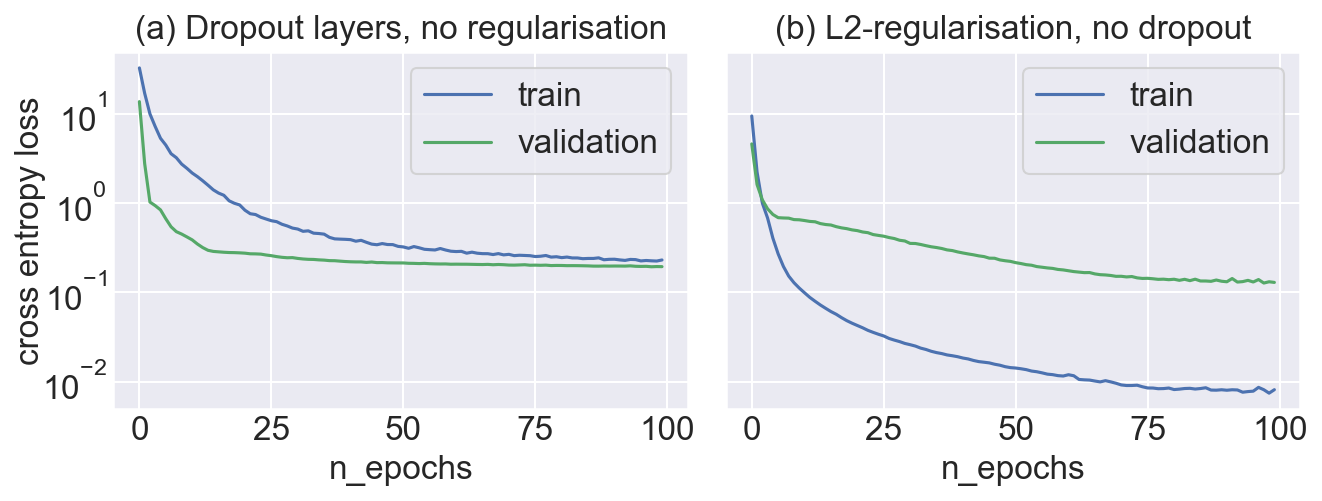

In [45]:
# with open("dropout_vs_regularisation.json", "w") as f:
#     json.dump( trains, f, indent=2 )

import matplotlib.pyplot as plt
import json 

with open("dropout_vs_regularisation.json", "r") as f:
    trains = json.load(f)
    
dropout_, weight_ = trains
fig,axs = plt.subplots(ncols=2, figsize=(9,3.5), sharey=True, dpi=150)
fontsize=16
axs[0].plot(range(100), dropout_[0], label="train", color="#4c72b0")
axs[0].plot(range(100), dropout_[1], label="validation", color="#55a868")
axs[0].set_title("(a) Dropout layers, no regularisation", fontsize=fontsize)
axs[1].plot(range(100), weight_[0], label="train", color="#4c72b0")
axs[1].plot(range(100), weight_[1], label="validation", color="#55a868")
axs[1].set_title("(b) L2-regularisation, no dropout", fontsize=fontsize)
axs[0].legend(fontsize=fontsize)
axs[1].legend(fontsize=fontsize)
# axs[0].grid()
# axs[1].grid()
axs[0].set_ylabel("cross entropy loss", fontsize=fontsize, labelpad=-2)
axs[0].set_yscale("log")
axs[0].set_xlabel("n_epochs",  fontsize=fontsize)
axs[1].set_xlabel("n_epochs",  fontsize=fontsize)
axs[0].tick_params("both", labelsize=fontsize, pad=-3)
axs[1].tick_params("both", labelsize=fontsize, pad=-3)
# axs[0].set_facecolor(color="lightblue")
fig.tight_layout()
fig.savefig("nn_learning_curve.png")

In [12]:
#Train NN with dropout prob = 0.7 on full dataset over 1000 epochs

#First use dataloader with GPU-loaded tensors
mps_device = torch.device("mps")
X_train = torch.from_numpy(X).float()
y_train = torch.from_numpy(y).float()
X_train = X_train.to(mps_device)
y_train = y_train.to(mps_device)
train_dataloader = DataLoader(list(zip(X_train,y_train)), shuffle=True, batch_size=X_train.shape[0]//10)

#Initialize neural network with dropout and Leaky-RELU
torch.manual_seed(1)
model = NeuralNetworkDropOut( X_train.shape[1], 4, 3, [1000, 500, 100], dropout_prob=0.7, leaky_slope=0.001 )
model.prob_predictor = nn.Softmax(dim=1)
model.loss = nn.CrossEntropyLoss(weight=torch.tensor([180/25, 180/25, 180/15, 180/115])) #Add class weights to balance the loss function
model.to(mps_device)

#Other hyper parameters for trainings
learning_rate = 0.001
weight_decay = 0.00
n_epochs=1000
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

def train_epochs(n_epochs, optimizer=optimizer):
    for epoch in range(n_epochs):
        mean_trainloss = 0
        num_trainbatches = len(train_dataloader)
        
        #Begin training on the batches
        model.train()
        for X_batch, y_batch in train_dataloader:
            optimizer.zero_grad()
            loss = model.loss_fn(X_batch, y_batch)
            mean_trainloss += loss.item()
            loss.backward()
            optimizer.step()
        mean_trainloss /= num_trainbatches
        
        #Begin evaluation after batching
        model.eval()
        with torch.no_grad():
            y_pred = model.predict(X_train).cpu().detach()
            y_pred = y_pred.numpy().argmax(axis=1)
            accuracy = balanced_accuracy_score(y_train.cpu().detach().numpy().reshape(-1), y_pred)
            
        print(f'Finished epoch {epoch}, latest trainloss {np.round(mean_trainloss,4)}, accuracy {np.round(accuracy,4)}')
        
finaltrain = train_epochs(n_epochs=n_epochs, optimizer=optimizer) 

Finished epoch 0, latest trainloss 82.8984, accuracy 0.25
Finished epoch 1, latest trainloss 51.2963, accuracy 0.25
Finished epoch 2, latest trainloss 36.6795, accuracy 0.2564
Finished epoch 3, latest trainloss 27.6687, accuracy 0.2894
Finished epoch 4, latest trainloss 21.983, accuracy 0.2883
Finished epoch 5, latest trainloss 18.2196, accuracy 0.2849
Finished epoch 6, latest trainloss 15.2032, accuracy 0.2947
Finished epoch 7, latest trainloss 13.4791, accuracy 0.318
Finished epoch 8, latest trainloss 11.4738, accuracy 0.3449
Finished epoch 9, latest trainloss 10.0859, accuracy 0.3768
Finished epoch 10, latest trainloss 8.8461, accuracy 0.403
Finished epoch 11, latest trainloss 7.8167, accuracy 0.4298
Finished epoch 12, latest trainloss 6.9958, accuracy 0.4518
Finished epoch 13, latest trainloss 6.3731, accuracy 0.4699
Finished epoch 14, latest trainloss 5.6432, accuracy 0.4821
Finished epoch 15, latest trainloss 5.1667, accuracy 0.4885
Finished epoch 16, latest trainloss 4.8639, acc

In [13]:
##Save/Load model from file
# torch.save(model.state_dict(), f"nn_3layers_1000-500-100_dropoutprob_0.7_nepochs_{n_epochs}_lr_{learning_rate}_statedict.zip")
# model.load_state_dict(torch.load("nn_3layers_statedict.zip"))
# model.eval()

In [14]:
##### Now for predicting on test set

#Load test data and vectorize
testset = load_dataset("test_data.json")
test_texts = [ sentencify(instance["text"]) for instance in testset ]
test_X = tfidf_vectorizer.transform( test_texts ).toarray()

#Include sentence length of test data normalised by maximum length on training data
test_lengths = np.zeros( (4000, 2) )
for i in range(4000):
    for k in range(2):
        lengths[i,k] = len(testset[i]['text'])**(k+1)
test_lengths[:,0] /= max_length
test_lengths[:,1] /= max_length_sqr
test_X = np.hstack( (test_X, test_lengths) )

#Feature selection on test data
test_X = selector.transform(test_X)

#Predictions on test data
test_y = model.predict( torch.from_numpy(test_X).float().to(mps_device) )
test_y = test_y.cpu().detach().numpy().reshape(-1,4)
test_y = test_y.argmax(axis=1)

test_y[ np.where(test_y==2) ] = 0 #domain2-ai -> AI = 0
test_y[ np.where(test_y==3) ] = 1 #domain1-human -> human = 1

In [15]:
#Export predictions
import pandas as pd
predictions = pd.DataFrame( test_y, index=range(4000), columns=[ "class" ])
predictions.to_csv("sample.csv", sep=",", header=True, index_label="id")

In [19]:
!kaggle competitions submit -c comp90051-2024s1-project-1 -f sample.csv -m "NN-3 hidden layers with dropout prob = 0.7, train on whole dataset with n_epochs={n_epochs}, lr=0.001"

100%|██████████████████████████████████████| 26.3k/26.3k [00:00<00:00, 30.4kB/s]
Successfully submitted to COMP90051 2024S1 Project 1